In [0]:
!git clone https://github.com/TheMrGhostman/Semi-supervised-Learning-with-VAE.git

Cloning into 'Semi-supervised-Learning-with-VAE'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 560 (delta 80), reused 201 (delta 60), pack-reused 332
Receiving objects: 100% (560/560), 223.31 MiB | 36.40 MiB/s, done.
Resolving deltas: 100% (166/166), done.
Checking out files: 100% (371/371), done.


In [0]:
import os 
os.chdir("Semi-supervised-Learning-with-VAE/")

In [0]:
import numpy as np 
import time

import torch 
import torch.nn as nn
import torch.nn.functional as F 

import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler

from utils.inference import Trainer, plot_loss
import utils.datasets as d

In [0]:
from utils.inception import Inception, InceptionBlock, correct_sizes
from utils import layers

In [0]:
X = np.vstack((np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt1.npy"),
               np.load("data/sequenced_data_for_VAE_length-160_stride-10_pt2.npy")))
y = np.load("data/sequenced_data_for_VAE_length-160_stride-10_targets.npy")

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)


In [0]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=666)

In [0]:
train = d.H_alphaSequences(X_train, y_train)
valid = d.H_alphaSequences(X_validation, y_validation)
test = d.H_alphaSequences(X_test, y_test)

In [0]:
def plot_loss1(obj, figsize=(25,18), downsample=None):
    """
    : param obj: 	Object type SVI or Trainer
    """
    loss_train = obj.loss_history["train"]
    axe_t = np.arange(len(loss_train))/10
    loss_val = obj.loss_history["validation"]
    axe_v = np.arange(len(loss_val))
    if downsample!=None:
        axe_t = axe_t[::downsample]
        loss_train = loss_train[::downsample]
    plt.figure(figsize=figsize)
    plt.plot(axe_t, loss_train, lw=0.5)
    plt.plot(axe_v, loss_val, lw=0.5)
    plt.ylabel("loss")
    plt.xlabel("Epochs")


    if "val_accuracy" in obj.loss_history.keys():
        print("plotting accuracy")
        plt.figure("Accuracy", figsize=figsize)
        plt.plot(obj.loss_history["val_accuracy"])
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.grid(True)
    plt.show()


In [0]:
class CRNN(nn.Module):
    def __init__(self, n_filters, kernel_sizes, rnn_out, sequence_len=160):
        super(CRNN, self).__init__()
        self.sequence_len = sequence_len
        # conv wants (batch, channel, length)
        self.reshape_to_inception = layers.Reshape(out_shape=(1, self.sequence_len))
        self.inception = Inception(
                in_channels=1, 
                n_filters=32, 
                kernel_sizes=[5, 11, 23],
                bottleneck_channels=32,
                activation=nn.ReLU()
            )
        # RNN wants #(batch, seq, feature)
        self.rnn1 = nn.LSTM(
            input_size=n_filters*4,
            hidden_size=rnn_out*4,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        self.rnn2 = nn.LSTM(
            input_size=rnn_out*4,
            hidden_size=rnn_out,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )
        #self.pool = nn.AdaptiveAvgPool1d(output_size=1)
        self.fc_on_rnn = nn.Linear(in_features=rnn_out, out_features=1)
        self.flatten = layers.Flatten(out_features=self.sequence_len)
        self.fc = nn.Linear(in_features=self.sequence_len, out_features=4)

    def forward(self, x_in):
        x = self.reshape_to_inception(x_in)
        x = self.inception(x)
        #print(x.shape)
        x = x.permute(0,2,1)
        #print(x.shape)
        x, (h, c) = self.rnn1(x)
        x, (h, c) = self.rnn2(x)
        #print(x.shape)
        #x = self.pool(x)
        x = self.fc_on_rnn(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        return self.fc(x)

In [0]:
mod = CRNN(n_filters=32, kernel_sizes=[5,11,23], rnn_out=20)

In [0]:
mod(torch.tensor(X_train[0:2, :]).float())

tensor([[ 7.7859e-07,  1.1001e-01, -1.7283e-02, -4.8707e-02],
        [ 4.9647e-03,  9.9752e-02, -1.7189e-02, -6.2294e-02]],
       grad_fn=<AddmmBackward>)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size=512, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset = valid, batch_size=512, shuffle=True)

In [0]:
optimizer= torch.optim.Adam(mod.parameters(), lr=1e-3)#5e-3

In [0]:
m1 = Trainer(
        model=mod,
        optimizer=optimizer,
        loss_function=nn.CrossEntropyLoss(),
        #scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20.35], gamma=0.2),
        tensorboard=False,
        model_name="CRNN_lr-1e-3,_bs-512_ks-[5,11,23]",
        verbose=True
        )

cuda:0


In [0]:
lh = m1(epochs=range(100), train_loader=train_loader, validation_loader=valid_loader)


Epoch [1/100], average_loss:0.8432, validation_loss:0.7217, val_accuracy:0.7013
Epoch [2/100], average_loss:0.6252, validation_loss:0.4711, val_accuracy:0.7662
Epoch [3/100], average_loss:0.4532, validation_loss:0.4160, val_accuracy:0.8312
Epoch [4/100], average_loss:0.4089, validation_loss:0.3861, val_accuracy:0.8571
Epoch [5/100], average_loss:0.3881, validation_loss:0.3493, val_accuracy:0.8442
Epoch [6/100], average_loss:0.3803, validation_loss:0.3614, val_accuracy:0.8182
Epoch [7/100], average_loss:0.3502, validation_loss:0.3407, val_accuracy:0.8571
Epoch [8/100], average_loss:0.3334, validation_loss:0.3603, val_accuracy:0.8701
Epoch [9/100], average_loss:0.3247, validation_loss:0.3305, val_accuracy:0.8831
Epoch [10/100], average_loss:0.3098, validation_loss:0.3129, val_accuracy:0.8442
Epoch [11/100], average_loss:0.3189, validation_loss:0.3265, val_accuracy:0.8442
Epoch [12/100], average_loss:0.3060, validation_loss:0.3381, val_accuracy:0.9221
Epoch [13/100], average_loss:0.3015, 

plotting accuracy


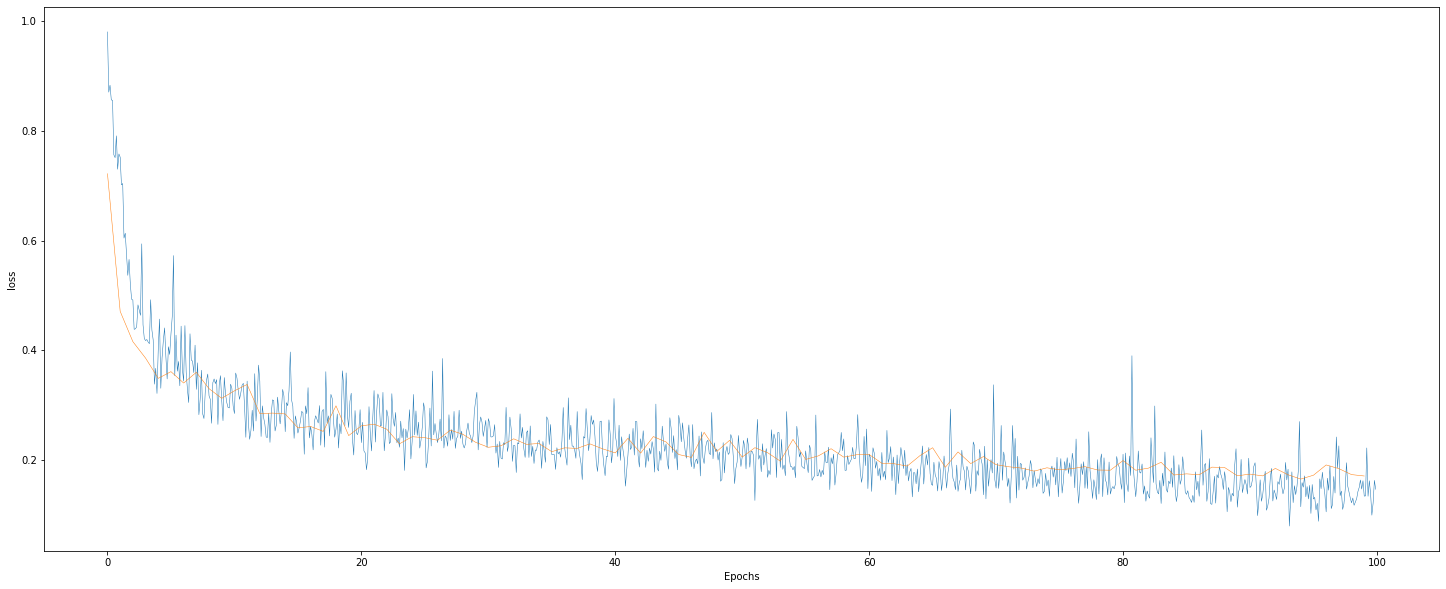

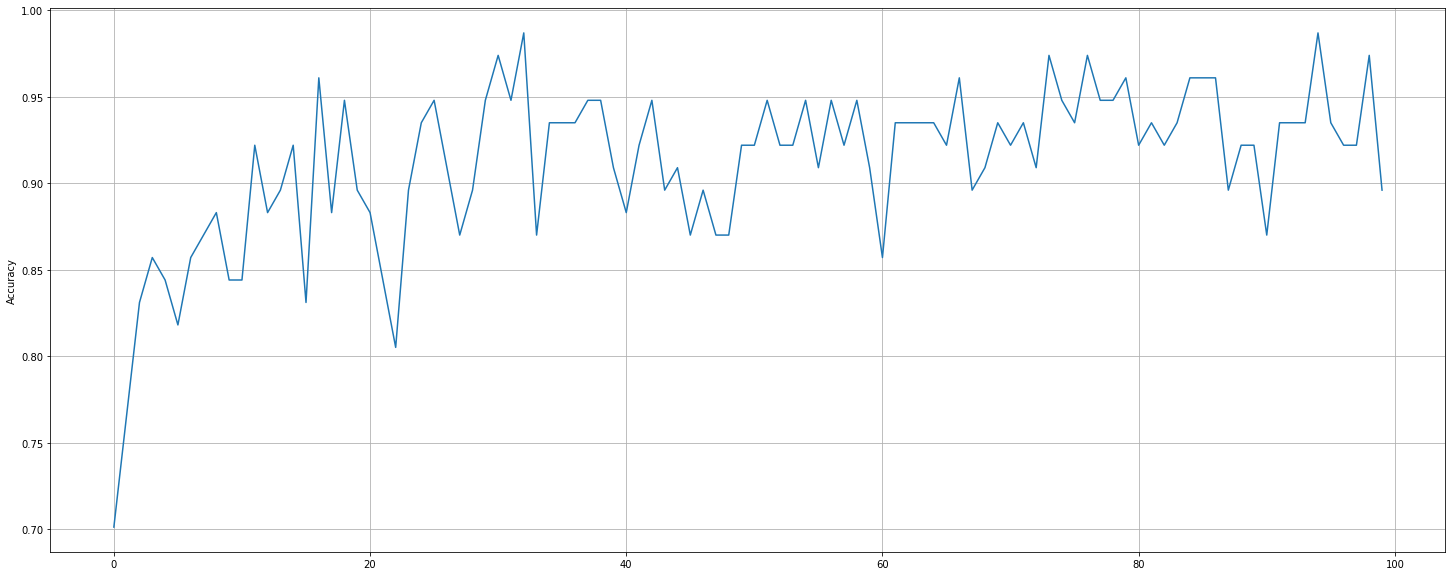

In [0]:
plot_loss1(m1, figsize=(25,10), downsample=None)

In [0]:
m1.model.eval()
#m1.model.cpu()
with torch.no_grad():
    x_pred = np.argmax(m1.model(torch.tensor(X_test).float().to(m1.device)).cpu().detach(), axis=1)
#m1.model.cuda()
x_pred

tensor([1, 1, 1,  ..., 0, 1, 0])

In [0]:
f1_score(y_true=y_test, y_pred=x_pred,average="macro")

0.9006934734750335

In [0]:
accuracy_score(y_true=y_test, y_pred=x_pred)

0.9392925430210325

In [0]:
confusion_matrix(y_true=y_test, y_pred=x_pred) # x_axis = predicted, y_axis = ground_truth

array([[ 3922,   131,    24,   158],
       [  324, 10049,    10,    62],
       [   19,    13,   419,    28],
       [  201,    32,    14,  1330]])

    InceptionTime Classification (best result so far)
    [ 3805,   296,    27,   107],
    [   91, 10307,     8,    39],
    [   22,     8,   425,    24],
    [  169,    37,    20,  1351]

In [0]:
torch.save(m1.model, "CRNN_lr-1e-3,_bs-512_ks-[5,11,23].pt")
torch.save(m1.model.state_dict(), "CRNN_lr-1e-3,_bs-512_ks-[5,11,23]-state_dict.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
